# Time Series Decomposition

This tutorial shows how to decompose AutoGP models into their constituent temporal components, to gain more insight into the learned time series structures.

We will demonstrate two methods.

- [`AutoGP.decompose`](@ref). This function breaks down a composite kernel into its constituent subkernels.
 
- [`AutoGP.extract_kernel`](@ref). This function extracts a specific primitive kernel from a composite kernel, while discarding the others.

In [1]:
import AutoGP

In [2]:
using CSV
using Dates
using DataFrames
using PythonPlot

## Loading Data

In [3]:
AutoGP.seed!(10)

In [4]:
data = CSV.File("assets/M1266.csv")
M3 = DataFrame(data);
df = M3[:,["ds","y"]];

We next split the data into a training set and test set.

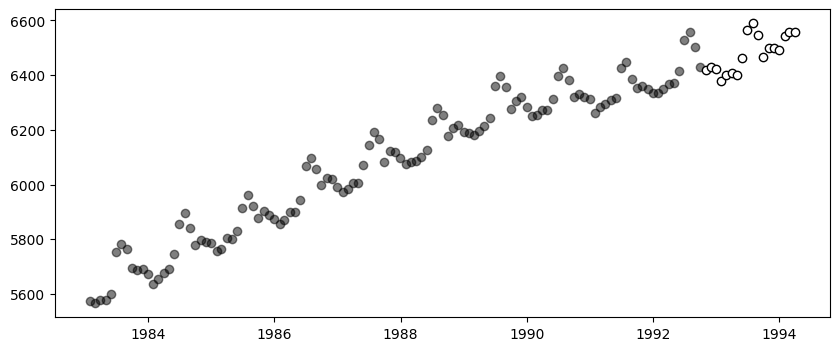

Python: <matplotlib.collections.PathCollection object at 0x71fc21baa480>

In [5]:
n_test = 18
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = PythonPlot.subplots(figsize=(10,4))
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", alpha=.5)
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Creating an AutoGP Model

In [6]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=18);

In [7]:
ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=4*size(df_test)[1])
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

Let us visualize the forecasts before model fitting. The model clearly underfits the data.

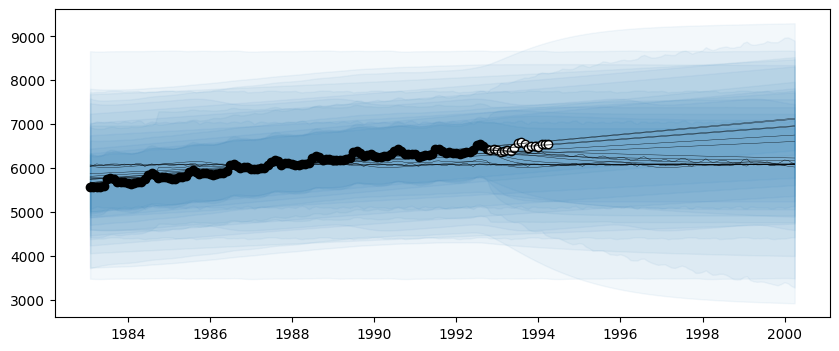

Python: <matplotlib.collections.PathCollection object at 0x71fc1d32ea20>

In [8]:
fig, ax = PythonPlot.subplots(figsize=(10,4))
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.25)
    ax.fill_between(subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"], color="tab:blue", alpha=0.05)
end
ax.scatter(df_train.ds, df_train.y, marker="o", color="k")
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Model Fitting via SMC

In [9]:
AutoGP.fit_smc!(model; schedule=AutoGP.Schedule.linear_schedule(n_train, .025), n_mcmc=50, n_hmc=25, verbose=false);

In [10]:
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

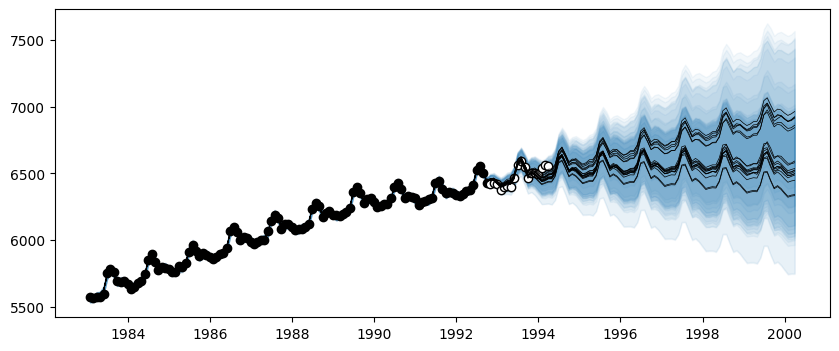

Python: <matplotlib.collections.PathCollection object at 0x71fc17d37290>

In [11]:
fig, ax = PythonPlot.subplots(figsize=(10,4))
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Hierarchical Decomposition of Kernels

Let us first inspect the learned kernels.

In [12]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

Model 1, Weight 0.09658896969666558


+
├── PER(0.77, 0.10; 0.03)
└── GE(1.79, 1.74; 0.20)


Model 2, Weight 0.039614762558316634


+
├── ×
│   ├── PER(0.74, 0.10; 0.03)
│   └── LIN(0.09; 0.46, 0.02)
└── GE(1.41, 1.73; 0.16)


Model 3, Weight 0.06625733864702288


+
├── PER(0.89, 0.10; 0.03)
└── GE(1.64, 1.73; 0.12)


Model 4, Weight 0.010545550106178718


+
├── ×
│   ├── +
│   │   ├── PER(0.73, 0.10; 0.04)
│   │   └── LIN(0.12; 0.48, 0.03)
│   └── LIN(0.76; 0.05, 0.03)
└── GE(1.12, 1.82; 0.09)


Model 5, Weight 0.01043051073070849


+
├── ×
│   ├── +
│   │   ├── PER(0.73, 0.10; 0.04)
│   │   └── LIN(0.25; 0.07, 0.24)
│   └── LIN(0.76; 0.05, 0.03)
└── GE(1.12, 1.82; 0.09)


Model 6, Weight 0.10089196157472988


+
├── PER(0.74, 0.10; 0.03)
└── +
    ├── LIN(1.36; 0.15, 0.06)
    └── GE(1.41, 1.73; 0.16)


Model 7, Weight 0.06760101185923048


+
├── PER(0.95, 0.10; 0.03)
└── GE(1.68, 1.77; 0.21)


Model 8, Weight 0.036215946339597245


+
├── PER(0.91, 0.10; 0.03)
└── +
    ├── GE(0.78, 1.73; 0.05)
    └── LIN(0.13; 0.08, 0.07)


Model 9, Weight 0.05838021457226862


+
├── PER(0.89, 0.10; 0.03)
└── GE(1.64, 1.73; 0.12)


Model 10, Weight 0.010614087663444665


+
├── ×
│   ├── +
│   │   ├── PER(1.04, 0.10; 0.04)
│   │   └── LIN(0.37; 0.07, 1.43)
│   └── LIN(0.13; 0.34, 0.06)
└── GE(1.62, 1.81; 0.10)


Model 11, Weight 0.03466466846299965


+
├── PER(0.91, 0.10; 0.03)
└── +
    ├── LIN(0.66; 0.14, 0.42)
    └── GE(0.78, 1.73; 0.05)


Model 12, Weight 0.061442233630051295


+
├── LIN(0.40; 0.22, 0.52)
└── +
    ├── PER(0.89, 0.10; 0.03)
    └── GE(1.64, 1.73; 0.12)


Model 13, Weight 0.04688201588759647


+
├── PER(0.95, 0.10; 0.03)
└── +
    ├── LIN(0.49; 0.10, 0.68)
    └── GE(1.53, 1.71; 0.06)


Model 14, Weight 0.07199528556277592


+
├── PER(0.67, 0.10; 0.03)
└── GE(1.09, 1.71; 0.16)


Model 15, Weight 0.039916775290948496


+
├── LIN(0.46; 0.03, 0.56)
└── +
    ├── PER(0.91, 0.10; 0.03)
    └── GE(0.78, 1.73; 0.05)


Model 16, Weight 0.06695006913745713


+
├── LIN(0.63; 0.13, 0.31)
└── +
    ├── PER(0.89, 0.10; 0.03)
    └── GE(1.22, 1.69; 0.09)


Model 17, Weight 0.09300479594368523


+
├── PER(0.74, 0.10; 0.03)
└── GE(1.41, 1.73; 0.16)


Model 18, Weight 0.08800380233632281


+
├── PER(0.67, 0.10; 0.03)
└── GE(1.09, 1.71; 0.16)


We now use [`AutoGP.decompose`](@ref) to hierarchically break down the composite kernel into all the constituent subkernels.

In [13]:
decomposed_models = AutoGP.decompose(model);

In [14]:
# Helper function to pretty print covariance.
function show_string(x)
    io = IOBuffer()
    Base.show(io, MIME("text/plain"), x)
    return String(take!(io))
end

# Plot the decomposition of `model` into its constituent parts.
function plot_decomposition(model::AutoGP.GPModel)
    kernels = AutoGP.covariance_kernels(model)
    forecasts = AutoGP.predict(
        model, ds_query;
        quantiles=[0.025, 0.975]);
    fig, axes = PythonPlot.subplots(
        nrows=AutoGP.num_particles(model),
        ncols=2,
        tight_layout=true,
        figsize=(12, 6*AutoGP.num_particles(model)),
        )
    for i=1:AutoGP.num_particles(model)
        subdf = forecasts[forecasts.particle.==i,:]
        # axes[i].set_title(show_string(kernels[i]), ha="left")
        axes[i-1,0].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=1, label=show_string(kernels[i]))
        axes[i-1,0].fill_between(
            subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
            color="tab:blue", alpha=0.05)
        axes[i-1,0].scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
        axes[i-1,0].scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
        axes[i-1,1].text(0.5, 0.5, show_string(kernels[i]), transform=axes[i-1,1].transAxes,  va="center", ha="left")
        axes[i-1,1].set_axis_off()
    end
    return fig, axes
end

plot_decomposition (generic function with 1 method)

Let us plot the decomposition of a given particle in the ensemble.

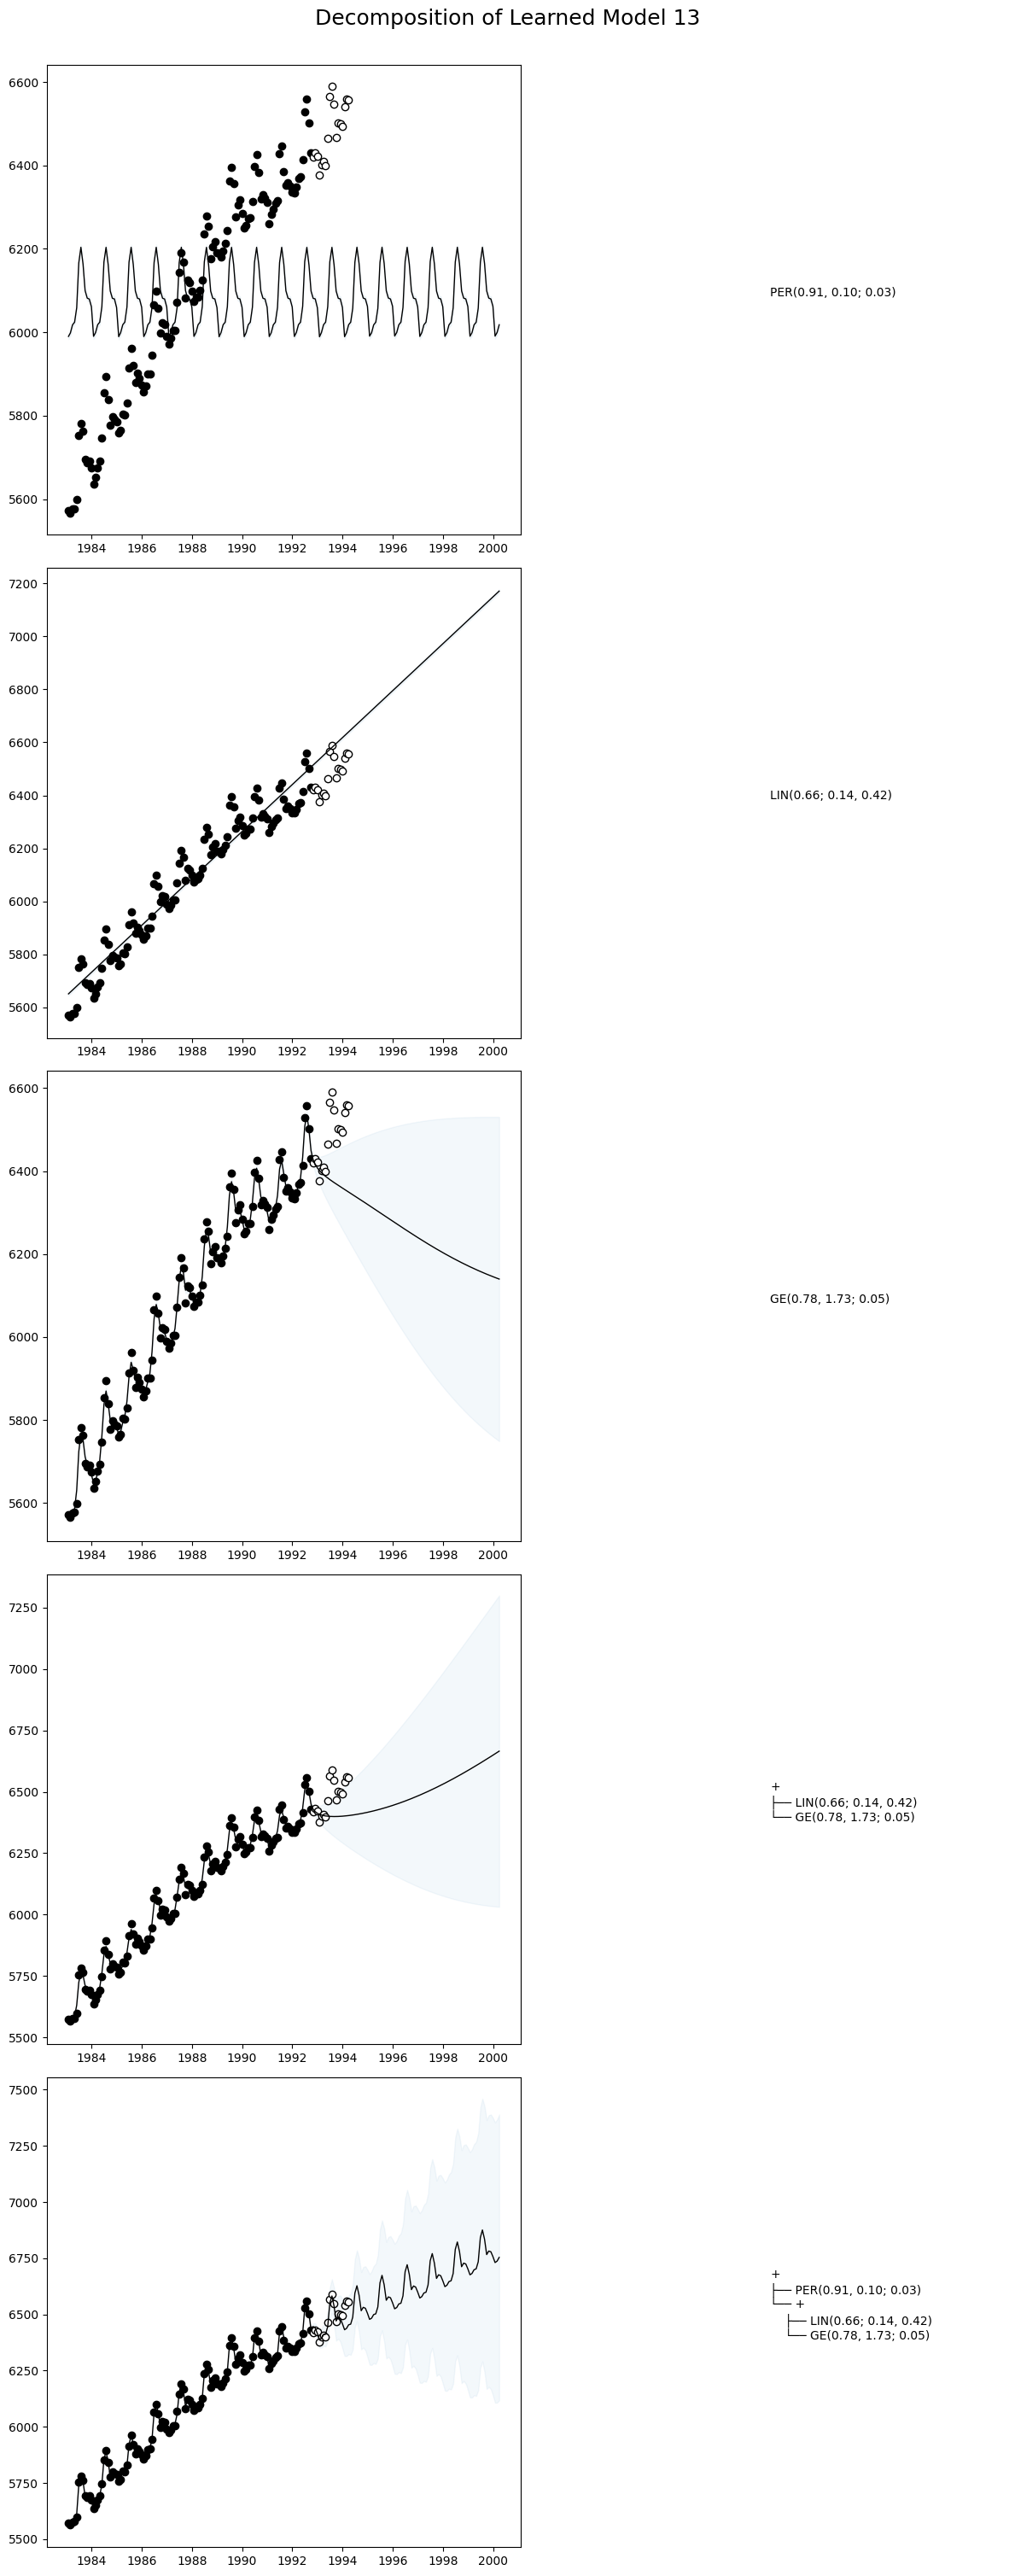

In [15]:
idx = 13
fig, ax = plot_decomposition(decomposed_models[11]);
fig.suptitle("Decomposition of Learned Model $(idx)", fontsize=18, va="center", y=1);

## "STL" Style Decomposition

An alternative approach to decomposing kernels is using [`AutoGP.extract_kernel`](@ref), which retains only a specific primitive kernel while discarding the others. In the following example, we will extract the [`AutoGP.GP.Linear`](@ref), [`AutoGP.GP.Periodic`](@ref), and [`AutoGP.GP.GammaExponential`](@ref) kernels from each learned particle to produce an "STL" style decomposition.

In [16]:
model_per = AutoGP.extract_kernel(model, AutoGP.GP.Periodic);
model_ge = AutoGP.extract_kernel(model, AutoGP.GP.GammaExponential);
model_lin = AutoGP.extract_kernel(model, AutoGP.GP.Linear);

Let us study the original and decomposed kernels for a given particle.

Unlike a [traditional time series decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series), which typically assumes a fixed additive or multiplicative structure, these decompositions retain the learned structure. For example, the decomposition for `Linear` may have a quadratic term, if the overall kernel has a subexpression of the form `LIN * LIN`.

The kernel structure is retained by using the [`AutoGP.GP.Constant`](@ref) to act as a "noop", as shown below. See also [`AutoGP.extract_kernel`](@ref) for full details.

In [17]:
idx = 2
println("Model $(idx) - FULL"); display(AutoGP.covariance_kernels(model)[2])
println("Model $(idx) - LIN only"); display(AutoGP.covariance_kernels(model_lin)[2])
println("Model $(idx) - PER only"); display(AutoGP.covariance_kernels(model_per)[2])
println("Model $(idx) - GE only"); display(AutoGP.covariance_kernels(model_ge)[2])

Model 2 - FULL


+
├── ×
│   ├── PER(0.74, 0.10; 0.03)
│   └── LIN(0.09; 0.46, 0.02)
└── GE(1.41, 1.73; 0.16)


Model 2 - LIN only


+
├── ×
│   ├── CONST(1.00)
│   └── LIN(0.09; 0.46, 0.02)
└── CONST(0.00)


Model 2 - PER only


+
├── ×
│   ├── PER(0.74, 0.10; 0.03)
│   └── CONST(1.00)
└── CONST(0.00)


Model 2 - GE only


+
├── ×
│   ├── CONST(1.00)
│   └── CONST(1.00)
└── GE(1.41, 1.73; 0.16)


We can now obtain forecasts corresponding to the Linear, Periodic, and GammaExponential components in each particle.

In [18]:
forecasts_lin = AutoGP.predict(model_lin, ds_query .+ Day(1); quantiles=[0.025, 0.975]);
forecasts_per = AutoGP.predict(model_per, ds_query .+ Day(1); quantiles=[0.025, 0.975]);
forecasts_ge = AutoGP.predict(model_ge, ds_query .+ Day(1); quantiles=[0.025, 0.975]);

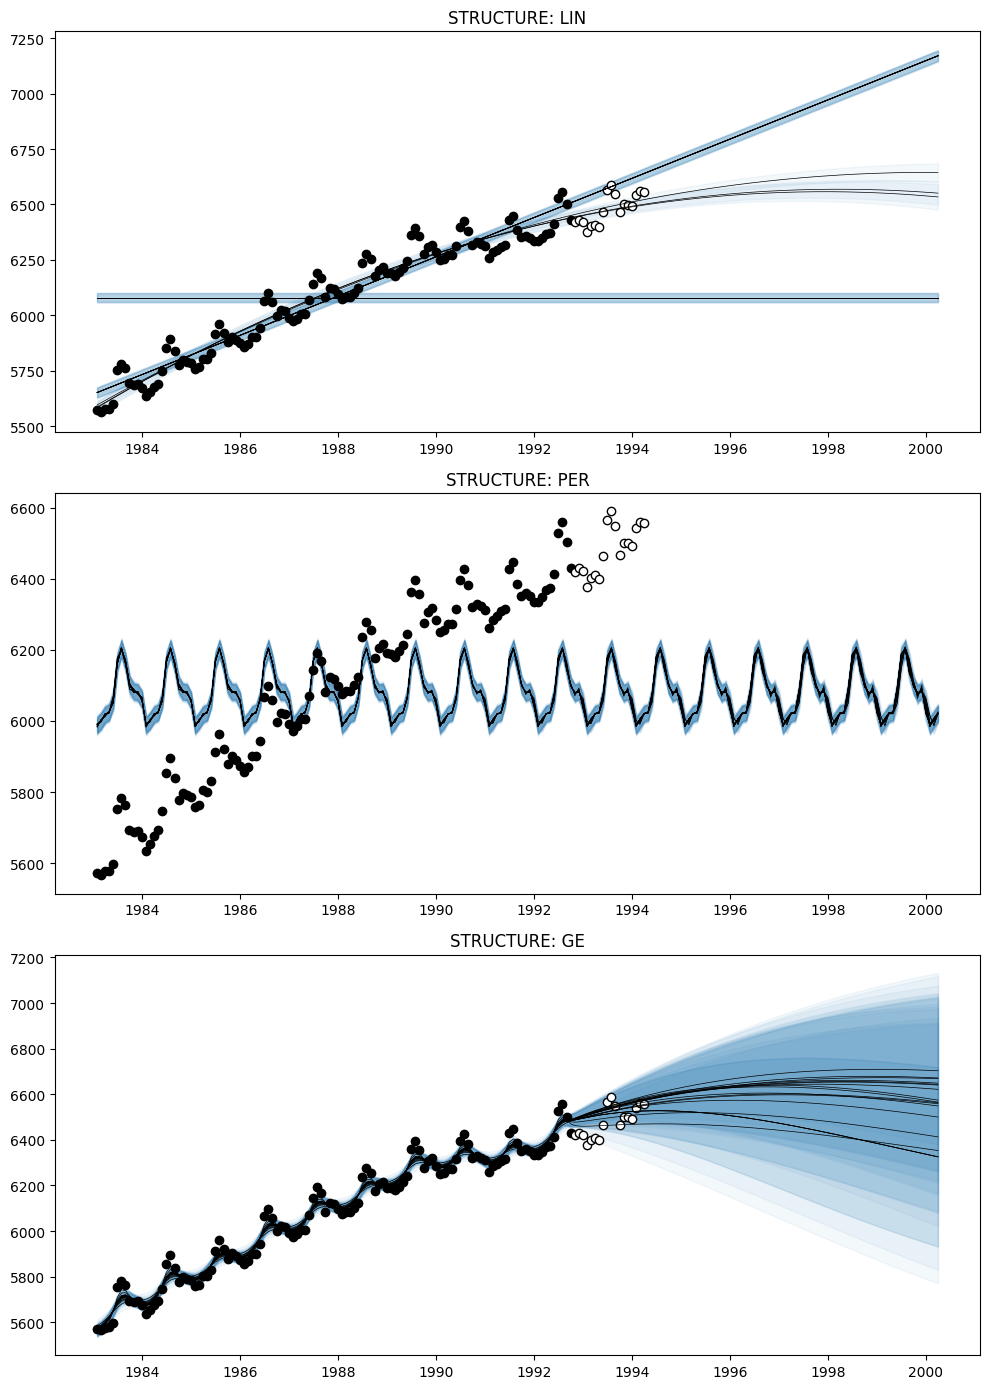

Python: Text(0.5, 1.0, 'STRUCTURE: GE')

In [19]:
fig, axes = PythonPlot.subplots(figsize=(10,14), nrows=3, tight_layout=true)
for (ax, m, f) in zip(axes, [model_lin, model_per, model_ge], [forecasts_lin, forecasts_per, forecasts_ge])
    for i=1:AutoGP.num_particles(m)
        subdf = f[f.particle.==i,:]
        ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
        ax.fill_between(subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"]; color="tab:blue", alpha=0.05)
    end
    ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
    ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
end
axes[0].set_title("STRUCTURE: LIN")
axes[1].set_title("STRUCTURE: PER")
axes[2].set_title("STRUCTURE: GE")